In [1]:
# https://www.researchgate.net/publication/313795371_Optimization_of_P_Median_Problem_in_Python_Using_PuLP_Package

from pulp import *
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
# 데이터 가져오기

files = []

for i in os.listdir():
    if i.endswith('.xlsx'):
        files.append(i)
        
files

['좌표_최종_용신동.xlsx',
 'Distance_Matrix.xlsx',
 '용신동 공공시설.xlsx',
 'Test_Distance_Matrix.xlsx']

In [3]:
d = pd.read_excel(files[1]).iloc[:, 1:8] # distance matrix, 가장 앞에 필요없는 index 칼럼 제거
w = pd.read_excel(files[0]).iloc[:, 0] # 수요 지점 i의 가중치 (택배 착지량)

In [4]:
# 문자열 -> km 단위의 실수형으로 변환

for j in range(d.shape[1]):
    for i in range(d.shape[0]):
        d.iloc[i, j] = d.iloc[i, j].replace(' km', '')
    d.iloc[:, j] = d.iloc[:, j].astype(float)
d.info()

names = d.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   동대문구청             342 non-null    float64
 1   용신동 주민센터          342 non-null    float64
 2   신설동 공영주차장         342 non-null    float64
 3   청계8노상공영주차장        342 non-null    float64
 4   용두동 청계 노상 공영 주차장  342 non-null    float64
 5   서울특별시교육청 동대문도서관   342 non-null    float64
 6   용두 어린이 영어 도서관     342 non-null    float64
dtypes: float64(7)
memory usage: 18.8 KB


In [5]:
# d의 row 수 -> 6 index i (수요지)
# d의 column 수 -> 6 index j (후보지)

d = d.values
d.shape

(342, 7)

In [6]:
I = range(d.shape[0]) # 수요지
J = range(d.shape[1]) # 후보지
P = 1 # 택배함 수

In [19]:
# 문제 구성
prob = LpProblem('P_Median', LpMinimize)

# 결정 변수
# a[i][j] -> 수요지 i가 후보지 j에 할당되면 1, 그렇지 않으면 0
a = LpVariable.dicts('a_blocks_%s_publics_%s', (I, J), cat = 'Binary')

# x[j] -> 후보지 j에 시설이 입지하면 1, 그렇지 않으면 0
x = LpVariable.dict('X_%s', J, cat = 'Binary')

# 목적 함수
prob += sum(sum(w[i] * d[i][j] * a[i][j] for j in J) for i in I)

# 제약식

prob += lpSum([x[j] for j in J]) == P

for i in I:
    prob += lpSum([a[i][j] for j in J]) == 1
    
for j in J:
    for i in I:
        prob += a[i][j] <= x[j]
        
prob.solve()

a_soln = np.array([[a[i][j].varValue for j in J] for i in I])
x_soln = np.array([x[j].varValue for j in J])

print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("a = ", a_soln)
print ("x = ", x_soln)

Status: Optimal
Population Served is =  1976411450.0999997
a =  [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
x =  [0. 0. 0. 0. 0. 0. 1.]


In [20]:
# 택배함 설치 수 증가

answers = []
zs = []

for p in range(1, 8):
    prob = LpProblem('P_Median', LpMinimize)
    a = LpVariable.dicts('a_blocks_%s_publics_%s', (I, J), cat = 'Binary')
    x = LpVariable.dict('X_%s', J, cat = 'Binary')
    prob += sum(sum(w[i] * d[i][j] * a[i][j] for j in J) for i in I)
    prob += lpSum([x[j] for j in J]) == p
    for i in I:
        prob += lpSum([a[i][j] for j in J]) == 1
    for j in J:
        for i in I:
            prob += a[i][j] <= x[j]
    prob.solve()
    a_soln = np.array([[a[i][j].varValue for j in J] for i in I])
    x_soln = np.array([x[j].varValue for j in J])
    print (("Status:"), LpStatus[prob.status])
    print ("Population Served is = ", value(prob.objective))
    print ("x = ", x_soln)
    answers.append(x_soln)
    zs.append(value(prob.objective))

Status: Optimal
Population Served is =  1976411450.0999997
x =  [0. 0. 0. 0. 0. 0. 1.]
Status: Optimal
Population Served is =  1630436590.5999997
x =  [0. 1. 0. 0. 0. 0. 1.]
Status: Optimal
Population Served is =  1584157671.099999
x =  [0. 1. 0. 0. 0. 1. 1.]
Status: Optimal
Population Served is =  1575447381.899999
x =  [0. 1. 0. 0. 1. 1. 1.]
Status: Optimal
Population Served is =  1568603318.6999993
x =  [0. 1. 1. 0. 1. 1. 1.]
Status: Optimal
Population Served is =  1562336329.3999994
x =  [1. 1. 1. 0. 1. 1. 1.]
Status: Optimal
Population Served is =  1560875483.7999992
x =  [1. 1. 1. 1. 1. 1. 1.]


In [14]:
for answer in tqdm(answer_by_p_num):
    print()
    for index, x in enumerate(answer):
        if x == 1:
            print(names[index])

100%|██████████| 7/7 [00:00<00:00, 3517.03it/s]


용두 어린이 영어 도서관

용신동 주민센터
용두 어린이 영어 도서관

용신동 주민센터
서울특별시교육청 동대문도서관
용두 어린이 영어 도서관

용신동 주민센터
용두동 청계 노상 공영 주차장
서울특별시교육청 동대문도서관
용두 어린이 영어 도서관

용신동 주민센터
신설동 공영주차장
용두동 청계 노상 공영 주차장
서울특별시교육청 동대문도서관
용두 어린이 영어 도서관

동대문구청
용신동 주민센터
신설동 공영주차장
용두동 청계 노상 공영 주차장
서울특별시교육청 동대문도서관
용두 어린이 영어 도서관

동대문구청
용신동 주민센터
신설동 공영주차장
청계8노상공영주차장
용두동 청계 노상 공영 주차장
서울특별시교육청 동대문도서관
용두 어린이 영어 도서관


In [16]:
import matplotlib.pyplot as plt

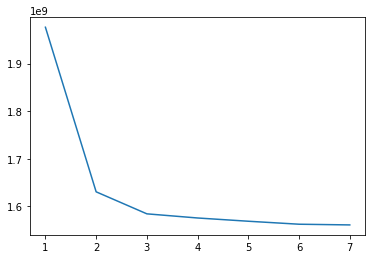

In [17]:
plt.plot(range(1, 8), zs)